In [ ]:
# Import Neccessary Libraries:

import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import pickle
from torch.optim.lr_scheduler import StepLR
import time
from PIL import Image
from torchsummary import summary
import time
import cv2

import seaborn as sns

pd.set_option('display.max_colwidth', -1)
pd.set_option("display.max_rows", 100000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [ ]:
# To mount drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Checking GPU:
print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def get_data_from_drive(copy = True, extract = True):
  start = time.time()
  if copy:
    print("Copying Train Source from Drive.")
    !cp "/content/drive/MyDrive/DS5500 Data/nasa_tropical_storm_competition_train_source.tar" -r "/content/nasa_tropical_storm_competition_train_source.tar"
    print("Copying Test Source from Drive.")
    !cp "/content/drive/MyDrive/DS5500 Data/nasa_tropical_storm_competition_test_source.tar" -r "/content/nasa_tropical_storm_competition_test_source.tar"
    print("Copying Train Metadata from Drive.")
    !cp "/content/drive/MyDrive/DS5500 Data/train.csv" -r "/content/train.csv"
    print("Copying Test Metadata from Drive.")
    !cp "/content/drive/MyDrive/DS5500 Data/test.csv" -r "/content/test.csv"

  if extract:
    print("Extracting Training Images")
    !tar -xvf "/content/nasa_tropical_storm_competition_train_source.tar" -C "/content/"
    print("Extracting Test Images")
    !tar -xvf "/content/nasa_tropical_storm_competition_test_source.tar" -C "/content/"
  
  print("Data Ready! Time Taken: {:.4f}s".format(time.time() - start))

  
def get_image_paths(data, image_dir, folder_name):
    data["image_path"] = image_dir + "/" + folder_name + "_" + data["image_id"] + "/" + "image.jpg"
    data = data[data.columns[[0, 2, 5, 1, 3, 4]]]
    return data
    

In [ ]:
def write_model_losses(filename, losses):
  print("Saving model losses to drive.")
  with open("/content/drive/MyDrive/DS5500 Data/{}.pkl".format(filename), "wb") as f:
    pickle.dump(losses, f)
    

def plot_predictions(wind_speed, metadata):
    sample_img = metadata[metadata.wind_speed == wind_speed][["image_path","predictions"]].iloc[:5]
    for i,img in enumerate(sample_img.image_path):
        # im = Image.open(img) 
        # im.show(title = sample_img["predictions"].iloc[i])
        image = mpimg.imread(img)
        plt.title("Actual: "+ str(wind_speed) +"   Predicted: " + str(round(sample_img["predictions"].iloc[i],2)))
        plt.imshow(image, cmap = "gray")
        plt.show()
    return 

def loadModel(model_path, model = None):
  state_dict = torch.load(model_path)
  model.load_state_dict(state_dict)
  return model

In [ ]:
# extract and save losses from model training print statements

def extract_and_save_losses_from_print_statements(loss_text, model_name, save=False):
  loss_text_list = loss_text.split("\n")
  loss_text_list = [text for text in loss_text_list if text.startswith("Epoch:")]
  loss_text_list = [text.split(",") for text in loss_text_list]
  # loss_text_list
  losses = {"train_loss": [], "valid_loss": []}
  for i in loss_text_list:
    losses["train_loss"].append(float(i[1].split(":")[1].strip()))
    losses["valid_loss"].append(float(i[2].split(":")[1].strip()))

  # model_name = "baseline_CNN_ADAM_0.0001"
  losses_filename = "{}_losses".format(model_name)
  if save:
    write_model_losses(losses_filename, losses)
  
  return losses

In [ ]:
def get_data_in_intervals(metadata, interval):
  
  data_dict = dict()
  counter = 0
  for name, group in metadata.groupby(by="storm_id"):
    group = group.sort_values(by="relative_time").reset_index()
    # print(name, group.index)
    # removing storms with just one rgb image
    if group.shape[0] > 2*interval+1:
      for i in range(0, group.shape[0]):
        i2 = i-interval
        i3 = i2-interval
        if i3 >= 0 and i2 > 0:
          # print(i, i2, i3)
          lis = [group.image_path[i3], group.image_path[i2], group.image_path[i]]
          # storm_id = metadata.storm_id[i3]
          wind_speed = group.wind_speed[i]

          if counter not in data_dict.keys():
            data_dict[counter] = {"storm_id": name, "image_list": lis, "wind_speed": wind_speed}
          counter += 1

  df = pd.DataFrame.from_dict(data_dict, orient="index").reset_index().drop(columns="index")

  return df

In [ ]:
def display_sample_images(dataloader, batch_size, sample_size, num_rows):

  sample_size = min(sample_size, batch_size)
  images, labels = next(iter(dataloader))
  images = images.numpy()

  fig = plt.figure(figsize = (30, 10))
  for i in np.arange(sample_size):
      ax = fig.add_subplot(num_rows, sample_size/num_rows, i+1, xticks = [], yticks = [])
      ax.imshow(np.squeeze(np.transpose(images[i], (1, 2 ,0))))
      ax.set_title("Wind Speed: {}".format(str(labels[i].item())))
      # ax.set_title(str(get_labels_for_one_hot(labels[i], class_dict)))
  
  return

In [ ]:
class HurricaneImageDataset(Dataset):

    def __init__(self, metadata, transforms, add_color=False):
        self.metadata = metadata # new: with list of image paths, wind speed
        self.transforms = transforms
        self.add_color = add_color

    def __len__(self):
        return len(self.metadata)

    def convert_to_threeband(self, img_list):
      def add_rgb_to_images(img):
        # create 1 pixel red image
        red = np.zeros((1, 1, 3), np.uint8)
        red[:] = (0,0,255)
        # resize lut to 256 values
        # # create 1 pixel blue image
        blue = np.zeros((1, 1, 3), np.uint8)
        blue[:] = (255,0,0)
        # resize lut to 256 values
        # # create 1 pixel green image
        green = np.zeros((1, 1, 3), np.uint8)
        green[:] = (0,255,0)
        # append the three images
        lut = np.concatenate((red, green, blue), axis=0)
        lut = cv2.resize(lut, (1,256), interpolation=cv2.INTER_CUBIC)
        # apply lut
        result = cv2.LUT(img, lut)
        return result
      
      # Reading the three images
      img1 = cv2.imread(img_list[0], cv2.IMREAD_GRAYSCALE) # t - 2*interval
      img2 = cv2.imread(img_list[1], cv2.IMREAD_GRAYSCALE) # t - interval
      img3 = cv2.imread(img_list[2], cv2.IMREAD_GRAYSCALE) # t

      # Merge the three images to convert to three equal channels
      img = cv2.merge((img3, img2, img1))
      # img = img/255
      # print(img)

      # Add color if True
      if self.add_color:
        img = add_rgb_to_images(img)
        
      # return np.asarray(img)
      # return img
      return Image.fromarray(img)

    def __getitem__(self, index):
      if torch.is_tensor(index):
          index = index.tolist()

      # rgb_image = []
      image_paths = self.metadata["image_list"][index]
      hurricane_image = self.convert_to_threeband(image_paths)
      # for ip in image_paths:
      #   img = Image.open(image_path)
      #   rgb_image.append(img)
      # hurricane_image = io.imread(image_path)
      
      label = self.metadata["wind_speed"][index]

      if self.transforms:
          hurricane_image = self.transforms(hurricane_image)

      return hurricane_image, label

In [ ]:
def train(model, trainloader, validloader, epochs, criterion, optimizer, scheduler, device, model_name, losses_filename):

  valid_loss_min = np.Inf
  losses = {"train_loss": [], "valid_loss": []}
  start = time.time()

  for e in range(1, epochs + 1):
    train_loss, valid_loss = 0.0, 0.0

    # Training the model:
    model.train()
    for data, target in trainloader:
        data, target = data.to(device), target.to(device)
        target = target.float().unsqueeze(1)
        optimizer.zero_grad()
        output = model(data)
        # print("Size: {}".format(output.size()))
        loss = criterion(output, target)
        loss.backward()
        # print(loss)
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    # Validating the model:
    model.eval()
    for data, target in validloader:
        data, target = data.to(device), target.to(device)
        target = target.float().unsqueeze(1)
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)
    
    if scheduler is not None:
        scheduler.step(valid_loss)

    train_loss = train_loss / len(trainloader.dataset)
    losses["train_loss"].append(train_loss)
    valid_loss = valid_loss / len(validloader.dataset)
    losses["valid_loss"].append(valid_loss)
    write_model_losses(losses_filename, losses)

    print("Epoch: {}/{}, Train Loss: {:.5f}, Validation Loss: {:.5f}".format(e, epochs, train_loss, valid_loss))


    if valid_loss <= valid_loss_min:
        print('Decrease in Validation Loss: ({:.6f} to {:.6f}). Saving Model...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), "/content/drive/MyDrive/DS5500 Data/{}.pt".format(model_name))
        valid_loss_min = valid_loss
    
  end = time.time()
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)
  print("\nTime Taken for Training: {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours),int(minutes),seconds))
  write_model_losses(losses_filename, losses)
    
  return losses 

In [ ]:
def model_evaluation(dataloader, model, criterion, device):
    # specify loss function
  predictions = torch.FloatTensor().cpu()
    # criterion = nn.MSELoss()
  total_MSE_loss, total_RMSE_loss = 0.0, 0.0
    # specify optimizer
    # optimizer = optim.Adam(model.parameters(), lr = 0.015)
  model.eval()
    # for data, target in validloader:
    #     data, target = data.to(device), target.to(device)
    #     target = target.float().unsqueeze(1)
    #     output = model(data)
    #     loss = criterion(output, target)
    #     valid_loss += loss.item() * data.size(0)
  with torch.no_grad():
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        target = target.float().unsqueeze(1)
        output = model(data)
        predictions = torch.cat((predictions, output.cpu()), 0)
        # print(predictions)
        #RMSE
        MSE_loss = criterion(output, target)
        RMSE_loss = torch.sqrt(MSE_loss)
        total_MSE_loss += MSE_loss.item()*data.size(0)
        total_RMSE_loss += RMSE_loss.item()*data.size(0)
    total_MSE_loss = total_MSE_loss / len(dataloader.dataset)
    total_RMSE_loss = total_RMSE_loss / len(dataloader.dataset)

  # pass entire testloader, get outputs and append to test_metadata
  preds_df = pd.DataFrame(predictions, columns = ['predictions']).astype("float")
  return preds_df, total_MSE_loss, total_RMSE_loss

In [ ]:
get_data_from_drive(copy=True, extract=True)

Streaming output truncated to the last 5000 lines.
nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_kzg_017/image.jpg
nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_kzg_017/stac.json
nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_kzg_017/features.json
nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_num_004/
nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_num_004/image.jpg
nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_num_004/stac.json
nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_num_004/features.json
nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_hld_147/
nasa_tropical_storm_competition_test_source/nasa_tropical_storm_competition_test_source_hld_147/image.jpg
nasa_

In [ ]:
rs = np.random.RandomState(111) # creating a random state for reproducibility of random generators
data_dir = "/content/"
train_metadata_og = pd.read_csv("{}/train.csv".format(data_dir))
test_metadata_og = pd.read_csv("{}/test.csv".format(data_dir))
# msk = rs.rand(len(train_metadata)) < 0.8
# train_metadata2 = train_metadata[msk].reset_index().drop("index", axis=1)
# valid_metadata = train_metadata[~msk].reset_index().drop("index", axis=1)

train_folder_name = "nasa_tropical_storm_competition_train_source"
test_folder_name = "nasa_tropical_storm_competition_test_source"
train_image_dir = "{}/{}".format(data_dir, train_folder_name)
test_image_dir = "{}/{}".format(data_dir, test_folder_name)

train_metadata = get_image_paths(train_metadata_og, train_image_dir, train_folder_name)
test_metadata = get_image_paths(test_metadata_og, test_image_dir, test_folder_name)
# valid_metadata = get_image_paths(valid_metadata, train_image_dir, train_folder_name)

interval = 9
train_metadata = get_data_in_intervals(train_metadata, interval)
# valid_metadata = get_data_in_intervals(valid_metadata, interval)
test_metadata = get_data_in_intervals(test_metadata, interval)

from sklearn.model_selection import train_test_split

X,y = train_metadata[["storm_id","image_list"]], train_metadata["wind_speed"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=101, stratify=train_metadata["storm_id"], shuffle=True)
X_train, X_valid = pd.DataFrame(X_train), pd.DataFrame(X_valid)
train_metadata = pd.concat([X_train, y_train], axis = 1).reset_index().drop("index", axis=1)
valid_metadata = pd.concat([X_valid, y_valid], axis = 1).reset_index().drop("index", axis=1)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


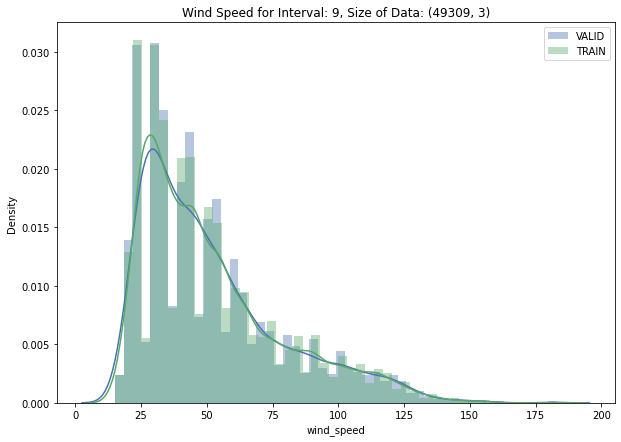

In [ ]:
  plt.figure(figsize=(10, 7))
  plt.title("Wind Speed for Interval: {}, Size of Data: {}".format(9, train_metadata.shape))
  sns.distplot(valid_metadata["wind_speed"], label="VALID")
  sns.distplot(train_metadata["wind_speed"], label="TRAIN")
  plt.legend()
  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


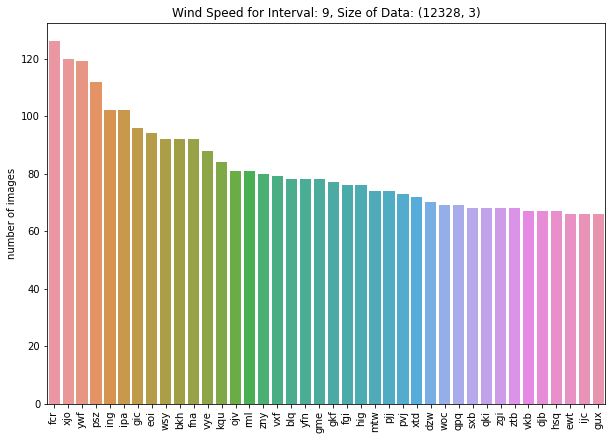

In [ ]:
  plt.figure(figsize=(10, 7))
  plt.title("Wind Speed for Interval: {}, Size of Data: {}".format(9, valid_metadata.shape))
  sns.barplot(valid_metadata["storm_id"].value_counts()[:40].index,valid_metadata["storm_id"].value_counts()[:40])
  # sns.barplot(train_metadata["storm_id"].value_counts(), label="TRAIN")
  plt.ylabel("number of images")
  plt.xticks(rotation=90)
  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


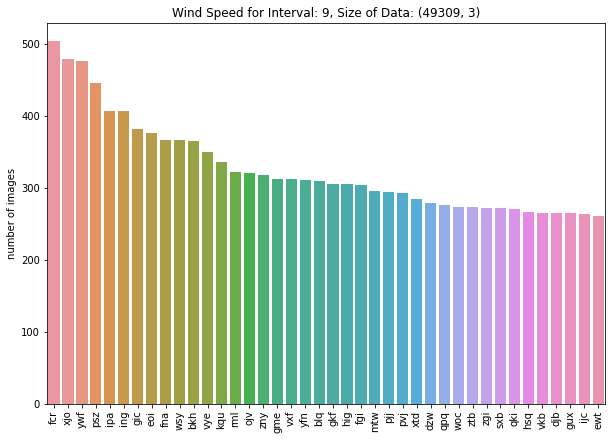

In [ ]:
  plt.figure(figsize=(10, 7))
  plt.title("Wind Speed for Interval: {}, Size of Data: {}".format(9, train_metadata.shape))
  sns.barplot(train_metadata["storm_id"].value_counts()[:40].index,train_metadata["storm_id"].value_counts()[:40])
  # sns.barplot(train_metadata["storm_id"].value_counts(), label="TRAIN")
  plt.ylabel("number of images")
  plt.xticks(rotation=90)
  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


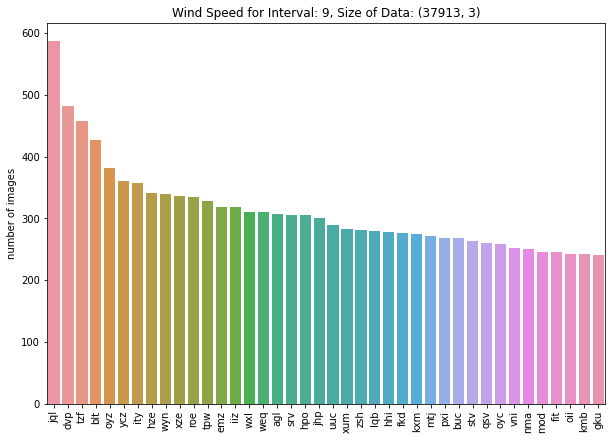

In [ ]:
  plt.figure(figsize=(10, 7))
  plt.title("Wind Speed for Interval: {}, Size of Data: {}".format(9, test_metadata.shape))
  sns.barplot(test_metadata["storm_id"].value_counts()[:40].index,test_metadata["storm_id"].value_counts()[:40])
  # sns.barplot(train_metadata["storm_id"].value_counts(), label="TRAIN")
  plt.ylabel("number of images")
  plt.xticks(rotation=90)
  plt.show()

In [ ]:
train_metadata.head()

,storm_id,image_list,wind_speed
0,xdn,"[/content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_xdn_015/image.jpg, /content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_xdn_024/image.jpg, /content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_xdn_033/image.jpg]",33
1,wbb,"[/content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_wbb_058/image.jpg, /content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_wbb_067/image.jpg, /content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_wbb_076/image.jpg]",48
2,frv,"[/content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_frv_046/image.jpg, /content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_frv_055/image.jpg, /content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_frv_064/image.jpg]",93
3,fvj,"[/content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_fvj_007/image.jpg, /content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_fvj_016/image.jpg, /content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_fvj_025/image.jpg]",30
4,pth,"[/content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_pth_081/image.jpg, /content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_pth_090/image.jpg, /content//nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_pth_099/image.jpg]",35


In [ ]:
transform = transforms.Compose([
        # transforms.RandomResizedCrop(224),
        transforms.Resize((366, 366)),
        # transforms.RandomRotation(90),
        # transforms.Grayscale(num_output_channels=1),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        # transforms.CenterCrop(90),
        transforms.ToTensor(),
        # transforms.Normalize([0.5], [0.5])
        # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
trainset = HurricaneImageDataset(train_metadata, transform)
testset = HurricaneImageDataset(test_metadata, transform)
validset = HurricaneImageDataset(valid_metadata, transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)
validloader = DataLoader(validset, batch_size=128, shuffle=True)

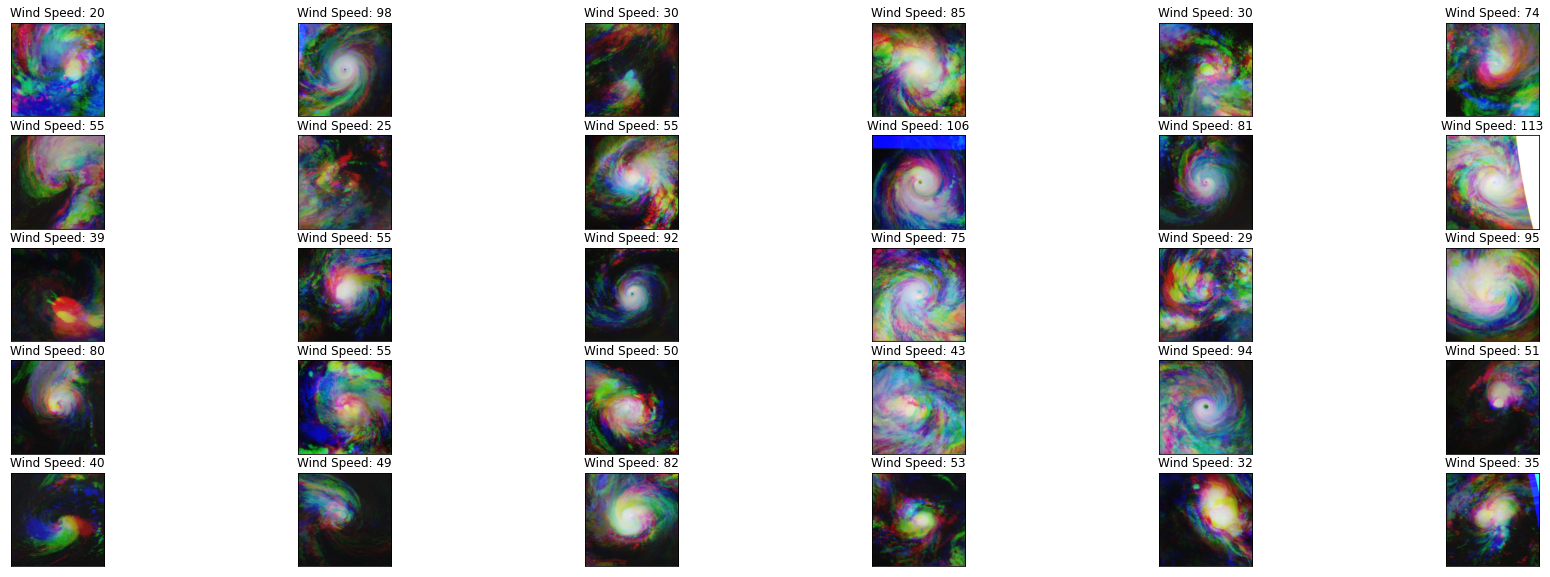

In [ ]:
sample_size = 30
batch_size = 128
num_rows = 5

display_sample_images(trainloader, batch_size, sample_size, num_rows)



In [ ]:
# Densenet161 Classifier


densenet161 = models.densenet161(pretrained = True)
# densenet161

# Freeze Parameters so we dont backprop through them:
for param in densenet161.parameters():
    param.requires_grad = False


# Create Custom Classifier:
classifier = nn.Sequential(nn.Linear(2208, 512),
                           nn.ReLU(),
                           nn.Dropout(0.20),
                           nn.Linear(512, 1))
                          #  nn.LogSoftmax(dim = 1))

# Assign Classifier
densenet161.classifier = classifier
densenet161.classifier

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

Sequential(
  (0): Linear(in_features=2208, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
# !pip install torchsummaryX
# from torchsummaryX import summary
# arch = summary(densenet161.to(device), torch.rand((1, 3, 256, 256)))
# summary(densenet161.to(device), torch.rand(10, 3, 224, 224).float().to(device))

In [ ]:
# model_name = "densenet161_ADAM_e50_b64_0001"
# model_path = "/content/drive/MyDrive/DS5500 Data/{}.pt".format(model_name)
# densenet161 = loadModel(model_path, densenet161)

DENSENET 161

Epochs: 35
Batch Size: 128
Learning Rate: 0.001
Optimizer: Adam
Criterion: MSELoss

In [ ]:
model = densenet161 # resize images to 366x366, batch_size = 64
model.to(device)
# print(model)

# Loss function
criterion = nn.MSELoss()
print("Loss Function:\n", criterion)
# Optimizer
print("")
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
factor = 0.3
# scheduler = ReduceLROnPlateau(optimizer, factor=0.3, patience=3, min_lr=lr*(factor**2), eps=1e-8, verbose=True)
scheduler = None
# optimizer = optim.SGD(model.parameters(), lr=0.0001)
print("Optimizer:\n", optimizer)

epochs = 20
model_name = "densenet161_ADAM_e50_b128_0001"
losses_filename = "{}_losses".format(model_name)
print("")
model_losses = train(model, trainloader, validloader, epochs, criterion, optimizer, scheduler, device, model_name, losses_filename)

Loss Function:
 MSELoss()

Optimizer:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

Saving model losses to drive.
Epoch: 1/20, Train Loss: 111.37002, Validation Loss: 105.08395
Decrease in Validation Loss: (inf to 105.083951). Saving Model...
Saving model losses to drive.
Epoch: 2/20, Train Loss: 109.19977, Validation Loss: 120.26505
Saving model losses to drive.
Epoch: 3/20, Train Loss: 108.46488, Validation Loss: 104.60715
Decrease in Validation Loss: (105.083951 to 104.607146). Saving Model...
Saving model losses to drive.
Epoch: 4/20, Train Loss: 107.97568, Validation Loss: 106.02957
Saving model losses to drive.
Epoch: 5/20, Train Loss: 109.85678, Validation Loss: 111.43194


KeyboardInterrupt: ignored

In [ ]:
# 8 hours 34 mins 50 seconds

densenet_loss_text =  """Epoch: 1/50, Train Loss: 421.91463, Validation Loss: 200.16645
Decrease in Validation Loss: (inf to 200.166452). Saving Model...
Epoch: 2/50, Train Loss: 169.38992, Validation Loss: 146.06454
Decrease in Validation Loss: (200.166452 to 146.064543). Saving Model...
Epoch: 3/50, Train Loss: 152.40829, Validation Loss: 133.88624
Decrease in Validation Loss: (146.064543 to 133.886243). Saving Model...
Epoch: 4/50, Train Loss: 145.35474, Validation Loss: 129.21787
Decrease in Validation Loss: (133.886243 to 129.217870). Saving Model...
Epoch: 5/50, Train Loss: 137.71567, Validation Loss: 130.01688
Epoch: 6/50, Train Loss: 134.78892, Validation Loss: 124.24605
Decrease in Validation Loss: (129.217870 to 124.246046). Saving Model...
Epoch: 7/50, Train Loss: 133.08393, Validation Loss: 125.90167
Epoch: 8/50, Train Loss: 129.96706, Validation Loss: 126.49502
Epoch: 9/50, Train Loss: 129.91057, Validation Loss: 119.50232
Decrease in Validation Loss: (124.246046 to 119.502316). Saving Model...
Epoch: 10/50, Train Loss: 124.90159, Validation Loss: 120.92633
Epoch: 11/50, Train Loss: 127.20242, Validation Loss: 118.14807
Decrease in Validation Loss: (119.502316 to 118.148073). Saving Model...
Epoch: 12/50, Train Loss: 127.47389, Validation Loss: 116.66511
Decrease in Validation Loss: (118.148073 to 116.665105). Saving Model...
Epoch: 13/50, Train Loss: 126.11199, Validation Loss: 118.28451
Epoch: 14/50, Train Loss: 123.57167, Validation Loss: 118.47975
Epoch: 15/50, Train Loss: 121.59777, Validation Loss: 114.96630
Decrease in Validation Loss: (116.665105 to 114.966305). Saving Model...
Epoch: 16/50, Train Loss: 121.67270, Validation Loss: 117.65913
Epoch: 17/50, Train Loss: 120.24484, Validation Loss: 114.74050
Decrease in Validation Loss: (114.966305 to 114.740503). Saving Model...
Epoch: 18/50, Train Loss: 120.58076, Validation Loss: 120.10572
Epoch: 19/50, Train Loss: 117.25474, Validation Loss: 116.80865
Epoch: 20/50, Train Loss: 116.34729, Validation Loss: 114.80283
Epoch: 21/50, Train Loss: 117.70991, Validation Loss: 112.09893
Decrease in Validation Loss: (114.740503 to 112.098933). Saving Model...
Epoch: 22/50, Train Loss: 115.96341, Validation Loss: 111.03032
Decrease in Validation Loss: (112.098933 to 111.030316). Saving Model...
Epoch: 23/50, Train Loss: 113.05546, Validation Loss: 123.80406
Epoch: 24/50, Train Loss: 115.69757, Validation Loss: 111.85278
Epoch: 25/50, Train Loss: 115.34157, Validation Loss: 114.85079
Epoch: 26/50, Train Loss: 112.35821, Validation Loss: 121.54835
Epoch: 27/50, Train Loss: 110.70526, Validation Loss: 121.43018
Epoch: 28/50, Train Loss: 112.42325, Validation Loss: 122.05347
Epoch: 29/50, Train Loss: 110.95975, Validation Loss: 106.83277
Decrease in Validation Loss: (111.030316 to 106.832770). Saving Model...
Epoch: 30/50, Train Loss: 111.73207, Validation Loss: 119.72131
Epoch: 1/20, Train Loss: 111.37002, Validation Loss: 105.08395
Decrease in Validation Loss: (inf to 105.083951). Saving Model...
Epoch: 2/20, Train Loss: 109.19977, Validation Loss: 120.26505
Epoch: 3/20, Train Loss: 108.46488, Validation Loss: 104.60715
Decrease in Validation Loss: (105.083951 to 104.607146). Saving Model...
Epoch: 4/20, Train Loss: 107.97568, Validation Loss: 106.02957
Epoch: 5/20, Train Loss: 109.85678, Validation Loss: 111.43194"""

In [ ]:
densenet_losses = extract_and_save_losses_from_print_statements(densenet_loss_text, model_name, save=True)

Saving model losses to drive.


In [ ]:
model_name

'densenet161_ADAM_e50_b64_0001'

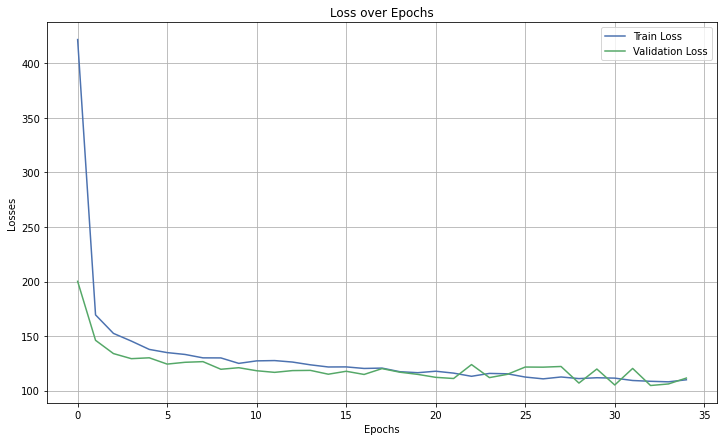

In [ ]:
plt.figure(figsize=(12, 7))
plt.title("Loss over Epochs")
plt.plot(densenet_losses["train_loss"])
plt.plot(densenet_losses["valid_loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend(["Train Loss", "Validation Loss"])
plt.grid("True")
plt.style.use("seaborn-deep")
plt.show()

In [ ]:
model_name = "densenet161_ADAM_e50_b64_0001"
model_path = "/content/drive/MyDrive/DS5500 Data/{}.pt".format(model_name)
densenet161 = loadModel(model_path, densenet161)

In [ ]:
# testloader = DataLoader(testset, batch_size=, shuffle=True)
best_model = densenet161.to(device)
predictions, total_MSE_loss, total_RMSE_loss = model_evaluation(trainloader, best_model, criterion, device)
res_df = pd.concat([train_metadata, predictions], axis=1)
# plot_predictions(valid_metadata.wind_speed[0], res_df)
print(total_MSE_loss,total_RMSE_loss)

92.57235460510174 9.584857070406608


In [ ]:
# testloader = DataLoader(testset, batch_size=, shuffle=True)
best_model = densenet161.to(device)
# criterion = nn.MSELoss()
predictions, total_MSE_loss, total_RMSE_loss = model_evaluation(validloader, best_model, criterion, device)
res_df = pd.concat([valid_metadata, predictions], axis=1)
# plot_predictions(valid_metadata.wind_speed[0], res_df)
print(total_MSE_loss,total_RMSE_loss)

104.6071460830322 10.188278562136086


In [ ]:
# testloader = DataLoader(testset, batch_size=, shuffle=True)
best_model = densenet161.to(device)
predictions, total_MSE_loss, total_RMSE_loss = model_evaluation(testloader, best_model, criterion, device)
res_df = pd.concat([test_metadata, predictions], axis=1)
# plot_predictions(valid_metadata.wind_speed[0], res_df)
print(total_MSE_loss, total_RMSE_loss)

112.06365813899083 10.537440158042177


VGG16

Epochs: 35
Batch Size: 128
Learning Rate: 0.001
Optimizer: Adam
Criterion: MSELoss

In [ ]:
# VGG16 Classifier:

vgg16 = models.vgg16(pretrained = True)
# vgg16

# Freeze Parameters so we dont backprop through them:
for param in vgg16.parameters():
    param.requires_grad = False

vgg16.classifier[6] = nn.Linear(4096, 1, bias = True)
# vgg16.classifier
vgg16.to(device)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model = vgg16 # resize images to 366x366, batch_size = 64
model.to(device)
# print(model)

# Loss function
criterion = nn.MSELoss()
print("Loss Function:\n", criterion)
# Optimizer
print("")
optimizer = optim.Adam(model.parameters(), lr = 0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.0001)
print("Optimizer:\n", optimizer)

epochs = 35
model_name = "VGG16_ADAM_e50_b128_0001"
losses_filename = "{}_losses".format(model_name)
print("")
model_losses = train(model, trainloader, validloader, epochs, criterion, optimizer, device, model_name, losses_filename)

Loss Function:
 MSELoss()

Optimizer:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

Saving model losses to drive.
Epoch: 1/35, Train Loss: 769.47775, Validation Loss: 353.10951
Decrease in Validation Loss: (inf to 353.109514). Saving Model...
Saving model losses to drive.
Epoch: 2/35, Train Loss: 294.09934, Validation Loss: 268.61016
Decrease in Validation Loss: (353.109514 to 268.610161). Saving Model...
Saving model losses to drive.
Epoch: 3/35, Train Loss: 251.89583, Validation Loss: 240.75485
Decrease in Validation Loss: (268.610161 to 240.754850). Saving Model...
Saving model losses to drive.
Epoch: 4/35, Train Loss: 232.94980, Validation Loss: 219.85537
Decrease in Validation Loss: (240.754850 to 219.855367). Saving Model...
Saving model losses to drive.
Epoch: 5/35, Train Loss: 223.53623, Validation Loss: 213.35558
Decrease in Validation Loss: (219.855367 to 213.355577). Saving Model...


RuntimeError: ignored

In [ ]:
plt.figure(figsize=(12, 7))
plt.title("Loss over Epochs")
plt.plot(model_losses["train_loss"])
plt.plot(model_losses["valid_loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend(["Train Loss", "Validation Loss"])
plt.grid("True")
plt.style.use("seaborn-deep")
plt.show()

In [ ]:
# testloader = DataLoader(testset, batch_size=, shuffle=True)
best_model = vgg16
predictions, total_MSE_loss, total_RMSE_loss = model_evaluation(trainloader, best_model, criterion, device)
res_df = pd.concat([train_metadata, predictions], axis=1)
# plot_predictions(valid_metadata.wind_speed[0], res_df)
print(total_MSE_loss,total_RMSE_loss)

In [ ]:
# testloader = DataLoader(testset, batch_size=, shuffle=True)
best_model = vgg16
predictions, total_MSE_loss, total_RMSE_loss = model_evaluation(validloader, best_model, criterion, device)
res_df = pd.concat([valid_metadata, predictions], axis=1)
# plot_predictions(valid_metadata.wind_speed[0], res_df)
print(total_MSE_loss,total_RMSE_loss)

In [ ]:
# testloader = DataLoader(testset, batch_size=, shuffle=True)
best_model = vgg16
predictions, total_MSE_loss, total_RMSE_loss = model_evaluation(testloader, best_model, criterion, device)
res_df = pd.concat([test_metadata, predictions], axis=1)
# plot_predictions(valid_metadata.wind_speed[0], res_df)
print(total_MSE_loss, total_RMSE_loss)

EFFICIENT NET B7 (BETTER PERFORMANCE THAN RESNET and DENSENET on Imagenet)

In [ ]:
efficientnet_b4 = models.efficientnet_b4(pretrained=True)

for param in efficientnet_b4.parameters():
    param.requires_grad = False

efficientnet_b4.classifier[1] = nn.Linear(in_features=1792, out_features=1, bias=True)
efficientnet_b4.classifier


Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1792, out_features=1, bias=True)
)

In [ ]:
model = efficientnet_b4 # resize images to 366x366, batch_size = 64
model.to(device)
# print(model)

# Loss function
criterion = nn.MSELoss()
print("Loss Function:\n", criterion)
# Optimizer
print("")
optimizer = optim.Adam(model.parameters(), lr = 0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.0001)
print("Optimizer:\n", optimizer)

epochs = 35
model_name = "efficientnet_b4_ADAM_e35_b128_0001"
losses_filename = "{}_losses".format(model_name)
print("")
model_losses = train(model, trainloader, validloader, epochs, criterion, optimizer, device, model_name, losses_filename)

Loss Function:
 MSELoss()

Optimizer:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

Saving model losses to drive.
Epoch: 1/35, Train Loss: 2509.62299, Validation Loss: 1801.85437
Decrease in Validation Loss: (inf to 1801.854373). Saving Model...
Saving model losses to drive.
Epoch: 2/35, Train Loss: 1372.63981, Validation Loss: 1043.31368
Decrease in Validation Loss: (1801.854373 to 1043.313676). Saving Model...
Saving model losses to drive.
Epoch: 3/35, Train Loss: 899.35600, Validation Loss: 703.56515
Decrease in Validation Loss: (1043.313676 to 703.565145). Saving Model...
Saving model losses to drive.
Epoch: 4/35, Train Loss: 694.75042, Validation Loss: 590.04923
Decrease in Validation Loss: (703.565145 to 590.049234). Saving Model...
Saving model losses to drive.
Epoch: 5/35, Train Loss: 572.13450, Validation Loss: 480.13151
Decrease in Validation Loss: (590.049234 to 480.131513). Saving Model...
Saving mod

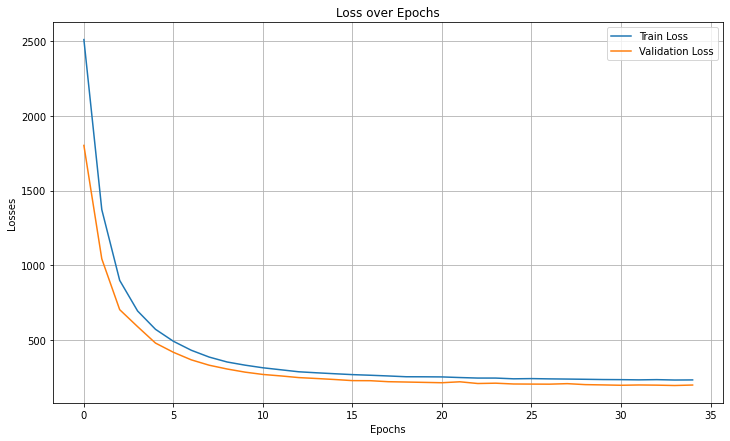

In [ ]:
plt.figure(figsize=(12, 7))
plt.title("Loss over Epochs")
plt.plot(model_losses["train_loss"])
plt.plot(model_losses["valid_loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend(["Train Loss", "Validation Loss"])
plt.grid("True")
plt.style.use("seaborn-deep")
plt.show()

In [ ]:
# testloader = DataLoader(testset, batch_size=, shuffle=True)
best_model = efficientnet_b4
predictions, total_MSE_loss, total_RMSE_loss = model_evaluation(trainloader, best_model, criterion, device)
res_df = pd.concat([train_metadata, predictions], axis=1)
# plot_predictions(valid_metadata.wind_speed[0], res_df)
print(total_MSE_loss,total_RMSE_loss)

194.9865444316182 13.922743472493256


In [ ]:
# testloader = DataLoader(testset, batch_size=, shuffle=True)
best_model = efficientnet_b4
predictions, total_MSE_loss, total_RMSE_loss = model_evaluation(validloader, best_model, criterion, device)
res_df = pd.concat([valid_metadata, predictions], axis=1)
# plot_predictions(valid_metadata.wind_speed[0], res_df)
print(total_MSE_loss,total_RMSE_loss)

199.60702412659128 14.078764719285415


In [ ]:
# testloader = DataLoader(testset, batch_size=, shuffle=True)
best_model = efficientnet_b4
predictions, total_MSE_loss, total_RMSE_loss = model_evaluation(testloader, best_model, criterion, device)
res_df = pd.concat([test_metadata, predictions], axis=1)
# plot_predictions(valid_metadata.wind_speed[0], res_df)
print(total_MSE_loss,total_RMSE_loss)

194.15612025139305 13.892932343381725


In [ ]:
# Densenet161 Classifier


densenet161 = models.densenet161(pretrained = True)
# densenet161

# Freeze Parameters so we dont backprop through them:
for param in densenet161.parameters():
    param.requires_grad = False


# # Create Custom Classifier:
classifier = nn.Sequential(nn.Linear(2208, 512),
                           nn.ReLU(),
                           nn.Dropout(0.20),
                           nn.Linear(512, 1))
                          #  nn.LogSoftmax(dim = 1))

# classifier = nn.Sequential(nn.Conv2d(3, 16, 5, stride=1, padding=2),
#                            nn.MaxPool2d(2, 2),
#                            nn.ReLU(),
#                            nn.Conv2d(16, 32, 5, stride=1, padding=2),
#                            nn.MaxPool2d(2, 2),
#                            nn.ReLU(),
#                            nn.Conv2d(32, 64, 5, stride=1, padding=2),
#                            nn.MaxPool2d(2, 2),
#                            nn.ReLU(),
#                            nn.Conv2d(64, 128, 5, stride=1, padding=2),
#                            nn.MaxPool2d(2, 2),
#                            nn.ReLU(),
#                            nn.Linear(128*22*22, 32),
#                            nn.ReLU(),
#                            nn.Dropout(0.25),
#                            nn.Linear(32, 1))



# Assign Classifier
densenet161.classifier = classifier
densenet161.classifier

Sequential(
  (0): Linear(in_features=2208, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
model = densenet161 # resize images to 366x366, batch_size = 64
model.to(device)
# print(model)

# Loss function
criterion = nn.MSELoss()
print("Loss Function:\n", criterion)
# Optimizer
print("")
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
factor = 0.3
scheduler = ReduceLROnPlateau(optimizer, factor=0.3, patience=3, min_lr=lr*(factor**2), eps=1e-8, verbose=True)
# scheduler = None
# optimizer = optim.SGD(model.parameters(), lr=0.0001)
print("Optimizer:\n", optimizer)
print("Scheduler:\n", scheduler)

epochs = 35
model_name = "densenet161_ADAM_e35_b128_0001_da_sched"
losses_filename = "{}_losses".format(model_name)
print("")
model_losses = train(model, trainloader, validloader, epochs, criterion, optimizer, scheduler, device, model_name, losses_filename)

Loss Function:
 MSELoss()

Optimizer:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Scheduler:

Saving model losses to drive.
Epoch: 1/35, Train Loss: 423.55802, Validation Loss: 270.07500
Decrease in Validation Loss: (inf to 270.075003). Saving Model...
Saving model losses to drive.
Epoch: 2/35, Train Loss: 175.61812, Validation Loss: 169.23512
Decrease in Validation Loss: (270.075003 to 169.235116). Saving Model...
Saving model losses to drive.
Epoch: 3/35, Train Loss: 160.78115, Validation Loss: 141.19272
Decrease in Validation Loss: (169.235116 to 141.192719). Saving Model...
Saving model losses to drive.
Epoch: 4/35, Train Loss: 153.96335, Validation Loss: 146.22250
Saving model losses to drive.
Epoch: 5/35, Train Loss: 148.07909, Validation Loss: 134.54627
Decrease in Validation Loss: (141.192719 to 134.546270). Saving Model...
Saving model losses to drive.
Epoch: 6/35, Train Loss: 145.01027, Validation Los

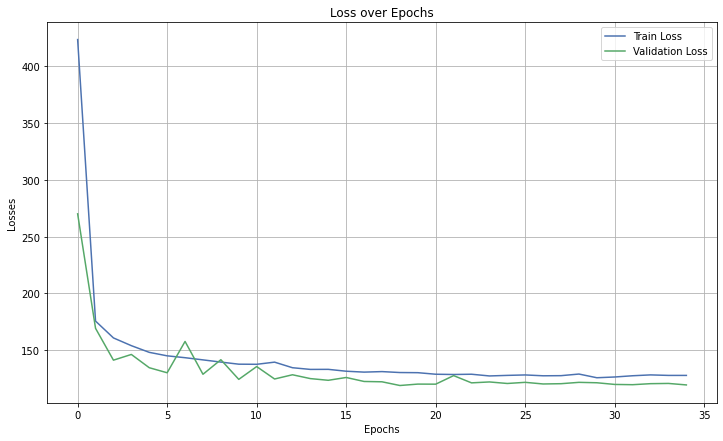

In [ ]:
plt.figure(figsize=(12, 7))
plt.title("Loss over Epochs")
plt.plot(model_losses["train_loss"])
plt.plot(model_losses["valid_loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend(["Train Loss", "Validation Loss"])
plt.grid("True")
plt.style.use("seaborn-deep")
plt.show()

In [ ]:
# testloader = DataLoader(testset, batch_size=, shuffle=True)
best_model = efficientnet_b4
predictions, total_MSE_loss, total_RMSE_loss = model_evaluation(trainloader, best_model, criterion, device)
res_df = pd.concat([train_metadata, predictions], axis=1)
# plot_predictions(valid_metadata.wind_speed[0], res_df)
print(total_MSE_loss,total_RMSE_loss)

In [ ]:
# testloader = DataLoader(testset, batch_size=, shuffle=True)
best_model = efficientnet_b4
predictions, total_MSE_loss, total_RMSE_loss = model_evaluation(validloader, best_model, criterion, device)
res_df = pd.concat([valid_metadata, predictions], axis=1)
# plot_predictions(valid_metadata.wind_speed[0], res_df)
print(total_MSE_loss,total_RMSE_loss)

In [ ]:
# testloader = DataLoader(testset, batch_size=, shuffle=True)
best_model = efficientnet_b4
predictions, total_MSE_loss, total_RMSE_loss = model_evaluation(testloader, best_model, criterion, device)
res_df = pd.concat([test_metadata, predictions], axis=1)
# plot_predictions(valid_metadata.wind_speed[0], res_df)
print(total_MSE_loss,total_RMSE_loss)

In [ ]:
# # model_names = ["densenet161_ADAM_e50_b128_0001", 
# #                "VGG16_ADAM_e50_b128_0001", 
# #                "efficientnet_b4_ADAM_e35_b128_0001",
# #                "densenet161_ADAM_e35_b128_0001_da_sched"]
# "densenet161_ADAM_e50_b128_0001"

# models = [densenet161, vgg16, efficientnet_b4, densenet161]

# loaders = [trainloader, validloader, testloader]
# loader_names = ["Train", "Validation", "Test"]

# criterion = nn.MSELoss()

# for name, model in zip(model_names, models):
#   print("Model: {}".format(name))
#   print("================================================")
#   model_path = "/content/drive/MyDrive/DS5500 Data/{}.pt".format(name)
#   model = loadModel(model_path, model)
#   model.to(device)
#   for loader_name, loader in zip(loader_names, loaders):
#     predictions, total_MSE_loss, total_RMSE_loss = model_evaluation(loader, model, criterion, device)
#     print("{} MSE: {}, {} RMSE: {}".format(loader_name, total_MSE_loss, loader_name, total_RMSE_loss))
#   print("\n")


Model: densenet161_ADAM_e50_b128_0001
Train MSE: 185.40209725908392, Train RMSE: 13.560414420605605
Validation MSE: 190.14126017556262, Validation RMSE: 13.734315385143915
Test MSE: 167.86884005064135, Test RMSE: 12.90614980958683


Model: VGG16_ADAM_e50_b128_0001


KeyboardInterrupt: ignored

In [ ]:
model_names = ["densenet161_ADAM_e35_b128_0001_da_sched", 
               "efficientnet_b4_ADAM_e35_b128_0001"]

models = [densenet161, efficientnet_b4]

loaders = [trainloader, validloader, testloader]
loader_names = ["Train", "Validation", "Test"]

criterion = nn.MSELoss()

for name, model in zip(model_names, models):
  print("Model: {}".format(name))
  print("================================================")
  model_path = "/content/drive/MyDrive/DS5500 Data/{}.pt".format(name)
  model = loadModel(model_path, model)
  model.to(device)
  for loader_name, loader in zip(loader_names, loaders):
    predictions, total_MSE_loss, total_RMSE_loss = model_evaluation(loader, model, criterion, device)
    print("{} MSE: {}, {} RMSE: {}".format(loader_name, total_MSE_loss, loader_name, total_RMSE_loss))
  print("\n")


Model: densenet161_ADAM_e35_b128_0001_da_sched
Train MSE: 119.9363210757359, Train RMSE: 10.914811796237752
Validation MSE: 120.69743505597965, Validation RMSE: 10.94897592818095
Test MSE: 117.61973127210615, Test RMSE: 10.801237340987544


Model: efficientnet_b4_ADAM_e35_b128_0001
Train MSE: 431016215.4996853, Train RMSE: 5731.292205691969
Validation MSE: 123446924.46035385, Validation RMSE: 3457.8134698688327
Test MSE: 364110087.62672174, Test RMSE: 5976.973349008602




###Densenet 161 Without Rotations

In [ ]:
model_name = "densenet161_ADAM_e35_b128_0001_da_wo_rotation_sched"
model_path = "/content/drive/MyDrive/DS5500 Data/{}.pt".format(model_name)
densenet161 = loadModel(model_path, densenet161)

In [ ]:
model = densenet161 # resize images to 366x366, batch_size = 64
model.to(device)
# print(model)

# Loss function
criterion = nn.MSELoss()
print("Loss Function:\n", criterion)
# Optimizer
print("")
# lr = 0.001
lr = 9.0000e-05 # retraining lr or lasst 5 epochs
optimizer = optim.Adam(model.parameters(), lr=lr)
factor = 0.3
scheduler = ReduceLROnPlateau(optimizer, factor=0.3, patience=3, min_lr=lr*(factor**2), eps=1e-8, verbose=True)
# scheduler = None
# optimizer = optim.SGD(model.parameters(), lr=0.0001)
print("Optimizer:\n", optimizer)
print("Scheduler:\n", scheduler)

epochs = 5
model_name = "densenet161_ADAM_e35_b128_0001_da_wo_rotation_sched"
losses_filename = "{}_losses".format(model_name)
print("")
model_losses = train(model, trainloader, validloader, epochs, criterion, optimizer, scheduler, device, model_name, losses_filename)

Loss Function:
 MSELoss()

Optimizer:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 9e-05
    weight_decay: 0
)
Scheduler:

Saving model losses to drive.
Epoch: 1/5, Train Loss: 118.92204, Validation Loss: 111.88042
Decrease in Validation Loss: (inf to 111.880416). Saving Model...
Saving model losses to drive.
Epoch: 2/5, Train Loss: 116.53136, Validation Loss: 114.37592
Saving model losses to drive.
Epoch: 3/5, Train Loss: 118.04191, Validation Loss: 111.71973
Decrease in Validation Loss: (111.880416 to 111.719733). Saving Model...
Saving model losses to drive.
Epoch: 4/5, Train Loss: 117.41073, Validation Loss: 112.23591
Saving model losses to drive.
Epoch: 5/5, Train Loss: 118.33520, Validation Loss: 114.24941

Time Taken for Training: 01:27:07.17

Saving model losses to drive.


In [ ]:
model_name = "densenet161_ADAM_e35_b128_0001_da_wo_rotation_sched"
loss_text = """Epoch: 1/35, Train Loss: 404.51353, Validation Loss: 173.88268
Decrease in Validation Loss: (inf to 173.882683). Saving Model...
Saving model losses to drive.
Epoch: 2/35, Train Loss: 170.46829, Validation Loss: 148.64566
Decrease in Validation Loss: (173.882683 to 148.645657). Saving Model...
Saving model losses to drive.
Epoch: 3/35, Train Loss: 155.60733, Validation Loss: 137.92773
Decrease in Validation Loss: (148.645657 to 137.927729). Saving Model...
Saving model losses to drive.
Epoch: 4/35, Train Loss: 149.56414, Validation Loss: 150.19154
Saving model losses to drive.
Epoch: 5/35, Train Loss: 145.85611, Validation Loss: 128.41709
Decrease in Validation Loss: (137.927729 to 128.417087). Saving Model...
Saving model losses to drive.
Epoch: 6/35, Train Loss: 141.07003, Validation Loss: 128.92319
Saving model losses to drive.
Epoch: 7/35, Train Loss: 139.10846, Validation Loss: 126.48638
Decrease in Validation Loss: (128.417087 to 126.486382). Saving Model...
Saving model losses to drive.
Epoch: 8/35, Train Loss: 135.75143, Validation Loss: 123.29391
Decrease in Validation Loss: (126.486382 to 123.293915). Saving Model...
Saving model losses to drive.
Epoch: 9/35, Train Loss: 134.94421, Validation Loss: 129.75742
Saving model losses to drive.
Epoch: 10/35, Train Loss: 133.49726, Validation Loss: 127.98859
Saving model losses to drive.
Epoch: 11/35, Train Loss: 134.20741, Validation Loss: 127.61690
Epoch    12: reducing learning rate of group 0 to 3.0000e-04.
Saving model losses to drive.
Epoch: 12/35, Train Loss: 130.83223, Validation Loss: 123.53612
Saving model losses to drive.
Epoch: 13/35, Train Loss: 127.05933, Validation Loss: 119.34915
Decrease in Validation Loss: (123.293915 to 119.349150). Saving Model...
Saving model losses to drive.
Epoch: 14/35, Train Loss: 126.60642, Validation Loss: 120.82294
Saving model losses to drive.
Epoch: 15/35, Train Loss: 127.07348, Validation Loss: 118.54916
Decrease in Validation Loss: (119.349150 to 118.549164). Saving Model...
Saving model losses to drive.
Epoch: 16/35, Train Loss: 125.27416, Validation Loss: 121.01981
Saving model losses to drive.
Epoch: 17/35, Train Loss: 125.16080, Validation Loss: 119.42284
Saving model losses to drive.
Epoch: 18/35, Train Loss: 124.82737, Validation Loss: 118.58812
Saving model losses to drive.
Epoch: 19/35, Train Loss: 123.30427, Validation Loss: 118.53078
Decrease in Validation Loss: (118.549164 to 118.530776). Saving Model...
Saving model losses to drive.
Epoch: 20/35, Train Loss: 123.76176, Validation Loss: 116.58570
Decrease in Validation Loss: (118.530776 to 116.585699). Saving Model...
Saving model losses to drive.
Epoch: 21/35, Train Loss: 123.44871, Validation Loss: 115.97581
Decrease in Validation Loss: (116.585699 to 115.975814). Saving Model...
Saving model losses to drive.
Epoch: 22/35, Train Loss: 125.80158, Validation Loss: 117.66895
Saving model losses to drive.
Epoch: 23/35, Train Loss: 123.01354, Validation Loss: 118.28314
Saving model losses to drive.
Epoch: 24/35, Train Loss: 122.73689, Validation Loss: 116.06039
Saving model losses to drive.
Epoch: 25/35, Train Loss: 122.83910, Validation Loss: 114.39089
Decrease in Validation Loss: (115.975814 to 114.390888). Saving Model...
Saving model losses to drive.
Epoch: 26/35, Train Loss: 122.19788, Validation Loss: 125.07020
Saving model losses to drive.
Epoch: 27/35, Train Loss: 121.30937, Validation Loss: 119.99922
Saving model losses to drive.
Epoch: 28/35, Train Loss: 120.86897, Validation Loss: 115.89383
Epoch    29: reducing learning rate of group 0 to 9.0000e-05.
Saving model losses to drive.
Epoch: 29/35, Train Loss: 121.38865, Validation Loss: 117.67045
Saving model losses to drive.
Epoch: 30/35, Train Loss: 118.61762, Validation Loss: 112.72960
Decrease in Validation Loss: (114.390888 to 112.729600). Saving Model...
Saving model losses to drive.
Epoch: 31/35, Train Loss: 118.29615, Validation Loss: 111.74890
Decrease in Validation Loss: (112.729600 to 111.748903). Saving Model...
Saving model losses to drive.
Epoch: 1/5, Train Loss: 118.92204, Validation Loss: 111.88042
Decrease in Validation Loss: (inf to 111.880416). Saving Model...
Saving model losses to drive.
Epoch: 2/5, Train Loss: 116.53136, Validation Loss: 114.37592
Saving model losses to drive.
Epoch: 3/5, Train Loss: 118.04191, Validation Loss: 111.71973
Decrease in Validation Loss: (111.880416 to 111.719733). Saving Model...
Saving model losses to drive.
Epoch: 4/5, Train Loss: 117.41073, Validation Loss: 112.23591
Saving model losses to drive.
Epoch: 5/5, Train Loss: 118.33520, Validation Loss: 114.24941"""

In [ ]:
losses_dn_31 = extract_and_save_losses_from_print_statements(loss_text, densenet161, save=False)
model_losses = losses_dn_31

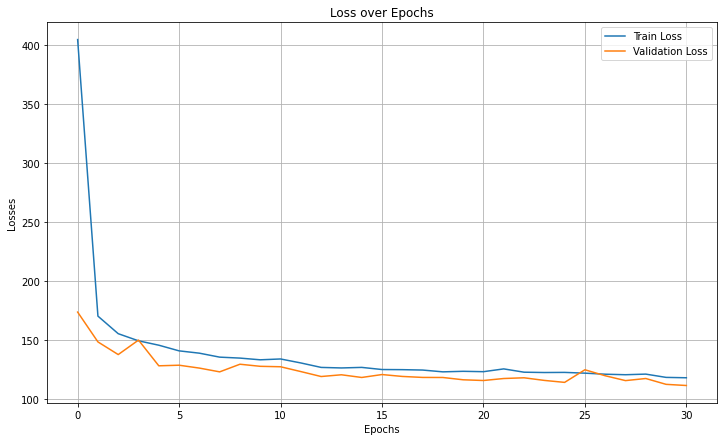

In [ ]:
plt.figure(figsize=(12, 7))
plt.title("Loss over Epochs")
plt.plot(model_losses["train_loss"])
plt.plot(model_losses["valid_loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend(["Train Loss", "Validation Loss"])
plt.grid("True")
plt.style.use("seaborn-deep")
plt.show()

In [ ]:
model_names = ["densenet161_ADAM_e35_b128_0001_da_wo_rotation_sched"]

models = [densenet161]

loaders = [trainloader, validloader, testloader]
loader_names = ["Train", "Validation", "Test"]

criterion = nn.MSELoss()

for name, model in zip(model_names, models):
  print("Model: {}".format(name))
  print("================================================")
  model_path = "/content/drive/MyDrive/DS5500 Data/{}.pt".format(name)
  model = loadModel(model_path, model)
  model.to(device)
  for loader_name, loader in zip(loader_names, loaders):
    predictions, total_MSE_loss, total_RMSE_loss = model_evaluation(loader, model, criterion, device)
    print("{} MSE: {}, {} RMSE: {}".format(loader_name, total_MSE_loss, loader_name, total_RMSE_loss))
  print("\n")
